# Build a decision tree model with scikit-learn

#### Decision trees are a great option when you need to build a classification model when the data won’t fit a linear model.

Decision tree models let you make predictions about **data classifications**. This can help with answering business questions such as:

- should a bank **accept** or **decline** a customer’s loan application?
- should an advertising agency target a customer by **email**, **text** or **letter**.

## Why use a decision tree model?

One of the benefits of decision trees is that you can look at the output to see how it matches your intuition about the data. It also makes it easier to share the logic with your business users, as it’s not just another black box model.

Another benefit is that the model automatically selects which input variables have the most impact on the classification. This means that you don’t have to worry about which input variables to include when fitting your model.

Let’s take a look at how to build a simple decision tree using this sample data I’ve put together.

The goal is to predict whether or not a customer has **life insurance** based on their **income** and **property status**.

This model could be used to prioritize marketing activity to customers which it predicts have a need for life insurance.

## Step 1: Import modules and data

First, let’s import the modules and data we’ll need for this.

`test_train_split` will be used to [split the data into train and test sets](https://theleftjoin.com/split-your-data-into-train-and-test-sets/).

`sklearn.tree` includes `DecisionTreeClassifier`, which will be used to **fit the model**. And `plot_tree`, which will be used to display a **graphical view** of the decision tree with `matplotlib.pyplot`.

In [ ]:
%pip install pandas scikit-learn matplotlib

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt

df = pd.read_csv("life_insurance_data.csv")
df

,income_usd,property_status,has_life_insurance
0,20500,Owner with Mortgage,0
1,31500,Owner with Mortgage,1
2,37000,Owner with Mortgage,0
3,47000,Owner with Mortgage,1
4,49000,Owner with Mortgage,0
5,55000,Owner with Mortgage,1
6,67500,Owner with Mortgage,1
7,72000,Owner with Mortgage,1
8,98000,Owner with Mortgage,1
9,102000,Owner with Mortgage,1


## Step 2: Look at the data

As with any machine learning project, it’s important to know what the data you’re working with looks like. This can give you some intuition about the variables you feed into the model, and what kind of results you can expect.

First, let’s take a look at the `income_usd` field, and what it looks like in relation to `has_life_insurance`. To do this, let's bin `income_usd` into buckets to make the data more readable. I’ve chosen bins of $25k here:

In [3]:
df['income_usd_bins'] = pd.cut(df['income_usd'], [0, 25000, 50000, 75000, 100000, 125000])
df.head()

,income_usd,property_status,has_life_insurance,income_usd_bins
0,20500,Owner with Mortgage,0,"(0, 25000]"
1,31500,Owner with Mortgage,1,"(25000, 50000]"
2,37000,Owner with Mortgage,0,"(25000, 50000]"
3,47000,Owner with Mortgage,1,"(25000, 50000]"
4,49000,Owner with Mortgage,0,"(25000, 50000]"


Now let’s see how many records we have in each income bin:

In [5]:
# pd.value_counts(df['income_usd_bins']).sort_index()
df['income_usd_bins'].value_counts().sort_index()

income_usd_bins
(0, 25000]           3
(25000, 50000]      12
(50000, 75000]       8
(75000, 100000]      6
(100000, 125000]     1
Name: count, dtype: int64

We can see that the 25k to 50k USD income bracket is where we have most observations. But we do have data points in the other buckets too, which may help our model.

Now let’s build a crosstab to see how the life insurance flag is split for the different income buckets.

**💡 Top Tip:** The `normalize='index'` option below calculates the values as percentage across the table.

In [6]:
pd.crosstab(df['income_usd_bins'], df['has_life_insurance'], normalize='index').style.format("{:.0%}")

has_life_insurance,0,1
income_usd_bins,,
"(0, 25000]",100%,0%
"(25000, 50000]",83%,17%
"(50000, 75000]",38%,62%
"(75000, 100000]",33%,67%
"(100000, 125000]",0%,100%


As you can see, the `has_life_insurance` percentages change as we move through the income bands. Where `0` indicates no life insurance, and `1` indicates the customer has insurance.

This suggests that income will be a valuable input for our model as it has explanatory value.

Now let's look at a crosstab by `property_status`. You can see that renters are less likely to have life insurance than those with a mortgage:

In [7]:
pd.crosstab(df['property_status'], df['has_life_insurance'], normalize='index').style.format("{:.0%}")

has_life_insurance,0,1
property_status,,
Owner Without Mortgage,70%,30%
Owner with Mortgage,30%,70%
Renter,80%,20%


## Step 3: One-hot encoding

Now that we have intuition about the relationship between our input and output variables. The next step is to transform the `property_status` column into numerical values, as the decision tree model doesn’t understand categorical string inputs.

In this case we’ll use **one-hot encoding** instaed of **label encoding** as the values `renter`, `Owner Without Mortgage` and `Owner with Mortgage` don’t have a natural ranking.

You can read this post to find out more about [transforming categorical values into numerical values](https://theleftjoin.com/encode-categorical-variables-ready-for-machine-learning/).

`property_status` will now be transformed into three different columns:

In [8]:
df = pd.get_dummies(df, columns=['property_status'], prefix=['property_status'])
df

,income_usd,has_life_insurance,income_usd_bins,property_status_Owner Without Mortgage,property_status_Owner with Mortgage,property_status_Renter
0,20500,0,"(0, 25000]",False,True,False
1,31500,1,"(25000, 50000]",False,True,False
2,37000,0,"(25000, 50000]",False,True,False
3,47000,1,"(25000, 50000]",False,True,False
4,49000,0,"(25000, 50000]",False,True,False
5,55000,1,"(50000, 75000]",False,True,False
6,67500,1,"(50000, 75000]",False,True,False
7,72000,1,"(50000, 75000]",False,True,False
8,98000,1,"(75000, 100000]",False,True,False
9,102000,1,"(100000, 125000]",False,True,False


## Step 4: Split data into input, output, train, and test sets

Now let’s split our data into **input** `X` and **output** `y` dataframes:

For the input, we drop the output field `has_life_insurance`. And `income_usd_bins`, which we used earlier when exploring the data.

In [9]:
X = df.drop(columns=['has_life_insurance', 'income_usd_bins'])
y = df['has_life_insurance']

And now let's split into **train** and **test** sets:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

This post as more details on how to [split your data into train and test sets](https://theleftjoin.com/split-your-data-into-train-and-test-sets/).

## Step 5: Fit the model

Now that our data is ready, it’s time to fit the decision tree model. We can feed in `X_train` and `y_train`:

In [11]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

Let’s take a look at what the decision tree looks like:

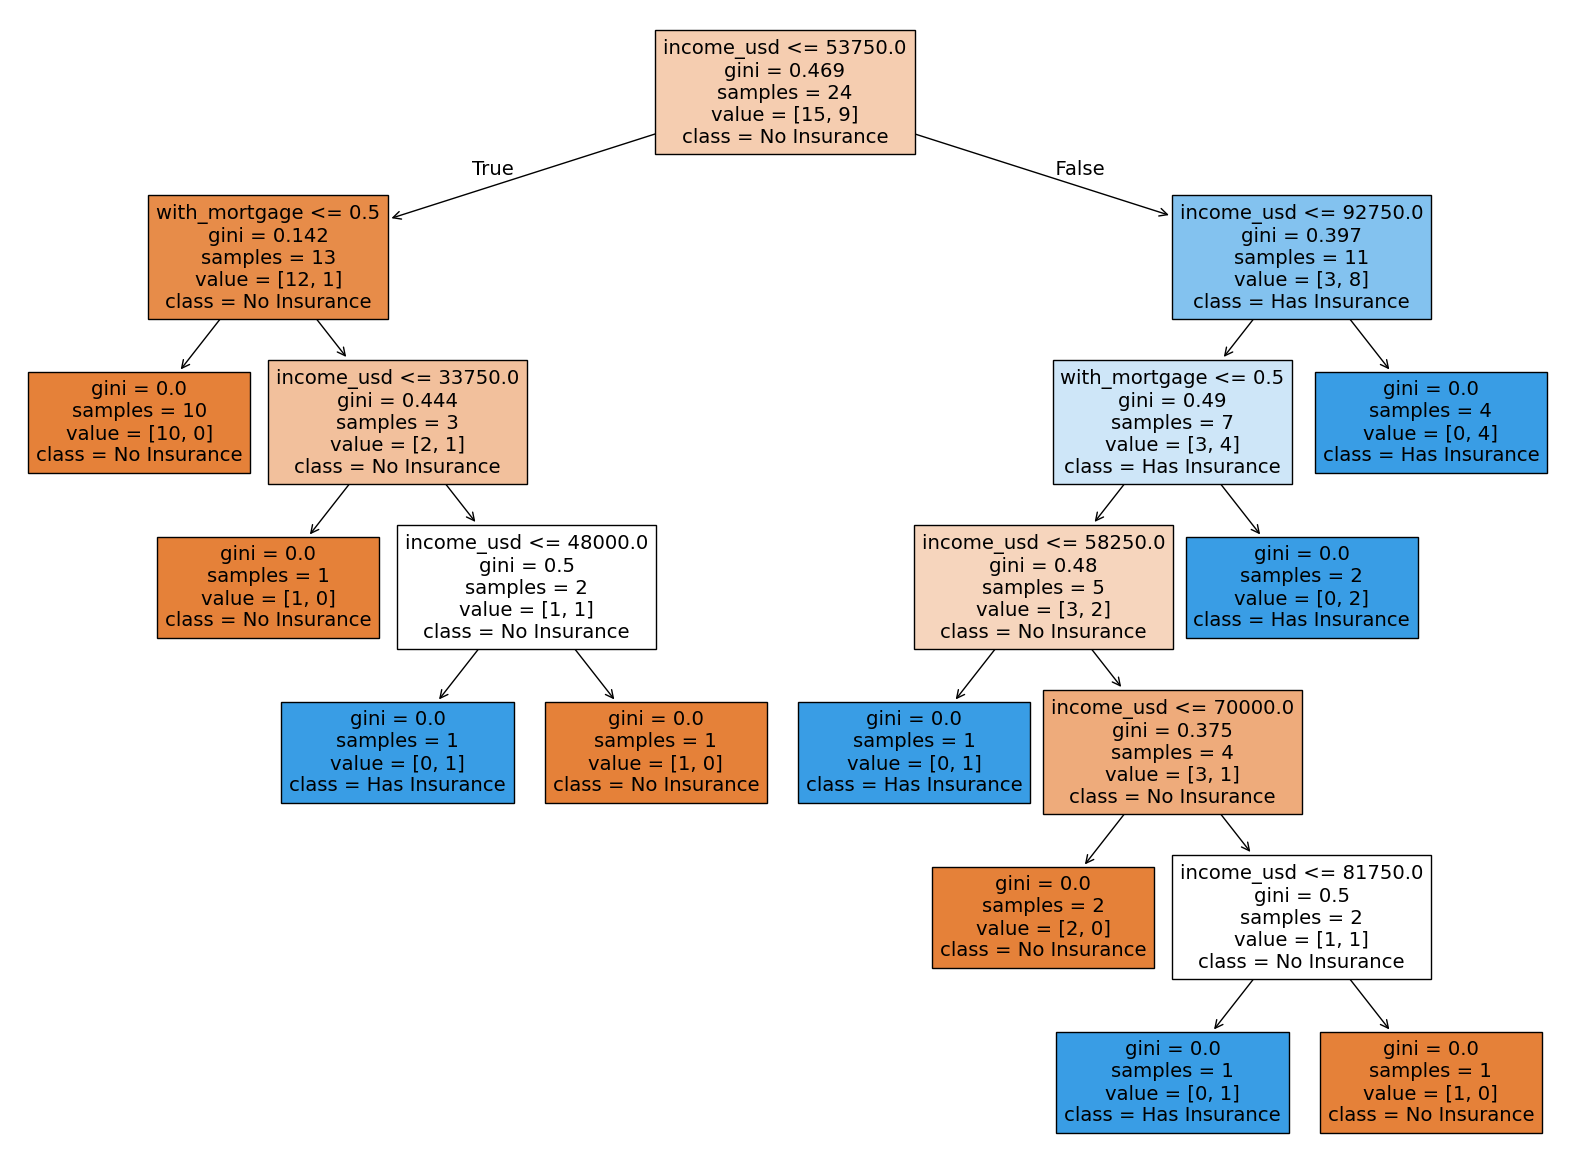

In [12]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(model,
                   feature_names=['income_usd', 'without_mortgage', 'with_mortgage', 'renter'],
                   class_names=['No Insurance', 'Has Insurance'],
                   filled=True
                   )

### How to read the decision tree output

**Line 1** of each decision node shows the **condition statement** e.g. `income_usd <= 53750`. If the answer is **True** then move down to the **left node**, otherwise go down to the **right node**.

**Line 2** shows the **gini index**, which is the probability that the classification would be incorrect if selected randomly - the closer this is to zero, the better this node is at classifying the data.

**Line 3** shows the **number of records** from our training dataframe which satisfy the condition of the node. You can see that the **first node** starts with **24 samples**, with **13 going to the left** and **11 going to the right**.

**Line 4** shows how many records correspond to the **value of the dependent variable** `has_life_insurance` in each node. E.g. the top node has **15 records** with **value 0** (no life insurance) and **9** with **value 1** (has life insurance).

**Line 5** shows the **classification** at that stage of the tree. If we were to stop the tree at the top level we should classify `has_life_insurance` as **'No Inaurance'** as at this level there’s a higher probability of the customer not having life insurance. Of course the classification becomes more accurate as we move down the tree.

By default, the tree keeps fitting the data until all records have been classified.

This means that all the **noise** included in the randomly selected **training data** has also been fitted. This is a problem, as the model should work for general data not already seen when training. If a model has been overfitted then it won’t perform as well when predicting values for unseen data.

## Step 6: Prune the tree

In order to overcome the problems of an overfitted tree, let’s specify `max_depth=3` when training the model:

In [13]:
model = tree.DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

You’ll see that we get a much neater tree, which does a good job of classifying the observations without overfitting.

You can experiment with the `max_depth` setting until you see gini values approaching zero, with the sample sizes in each node not going down too low - which would indicate overfitting.

**📌 Remember:** The **gini index** calculates the probability that the classification would be incorrect if selected randomly - the closer this is to zero, the better this node is at classifying the data.

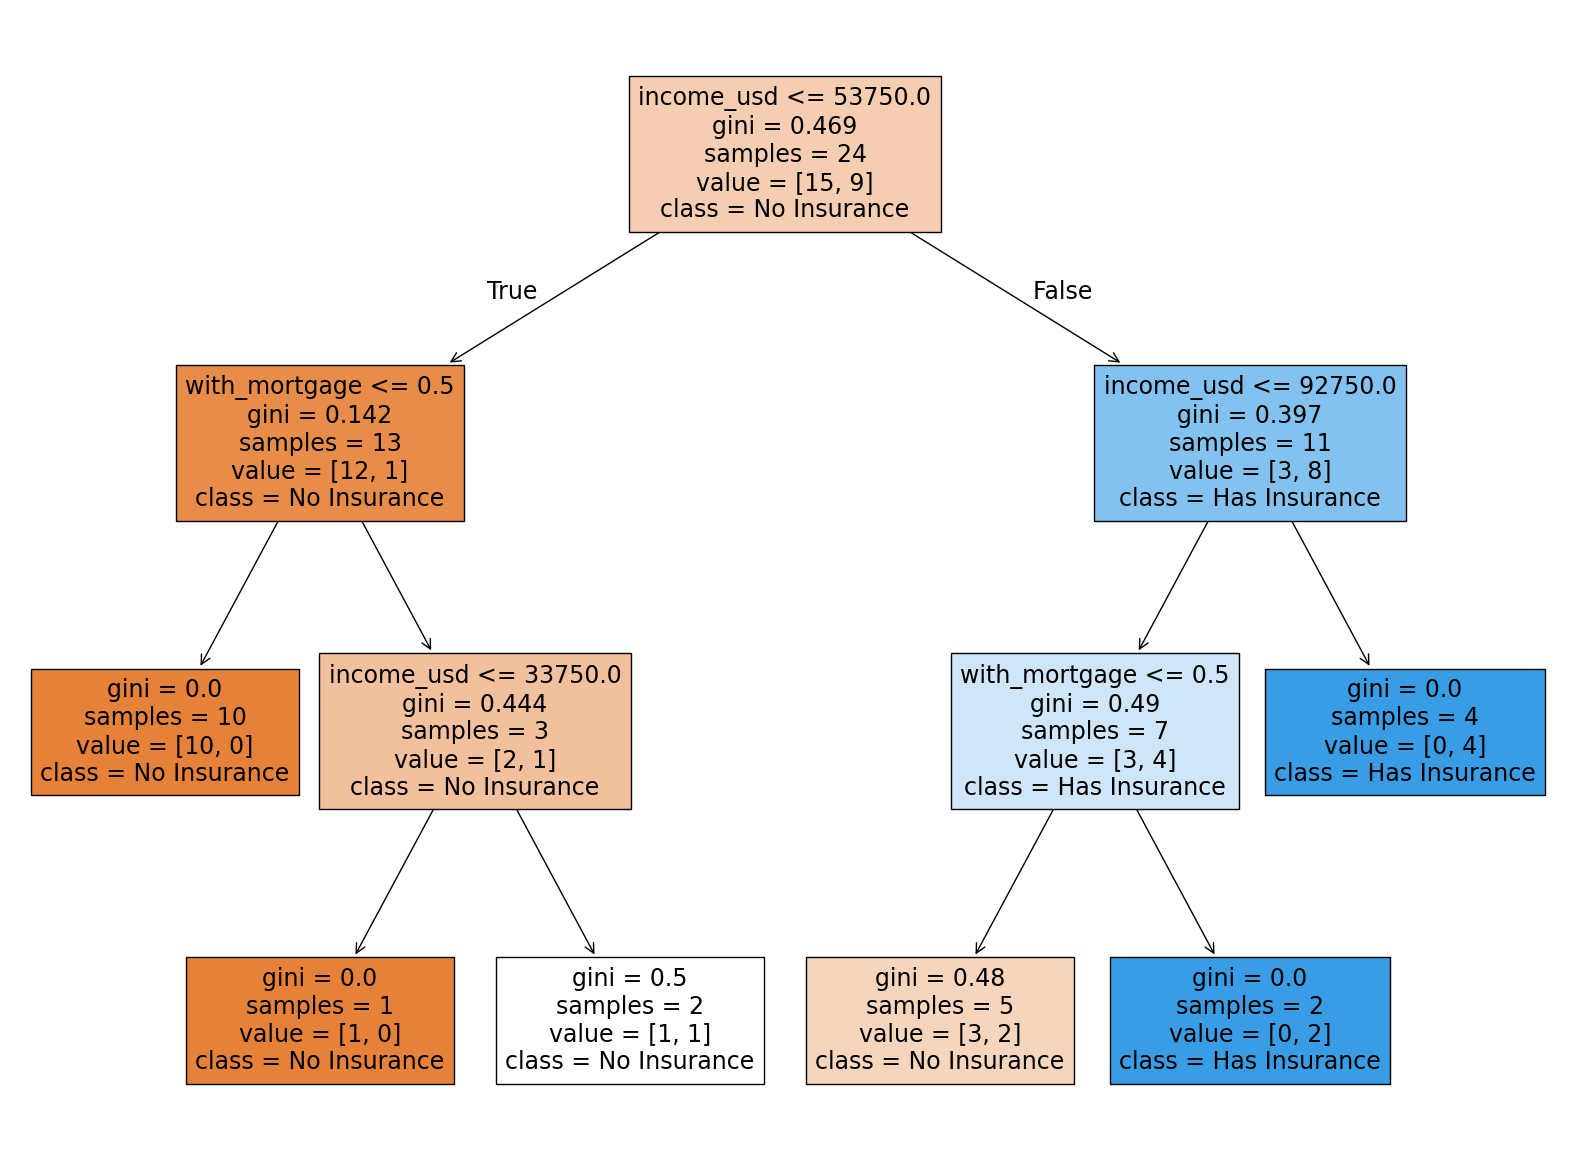

In [14]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(model,
                   feature_names=['income_usd', 'without_mortgage', 'with_mortgage', 'renter'],
                   class_names=['No Insurance', 'Has Insurance'],
                   filled=True
                   )

## Step 7: Check the accuracy

To check how our model performs, we can use the [accuracy score, confusion matrix, and F1-score](https://theleftjoin.com/check-the-accuracy-of-your-classification-model/).

If the accuracy wasn't as good as expected, then we'd need to consider increasing the sample size of our data, or choosing a different algorithm.

## Step 8: Make predictions

Now that you have your final model, you can use it to make predictions:

In [15]:
X_new_data_dict = {'income_usd': {0: 12000, 1: 44000, 2: 58000, 3: 72000, 4: 101000},
              'property_status_Owner Without Mortgage': {0: 1, 1: 0, 2: 0, 3: 1, 4: 0},
              'property_status_Owner with Mortgage': {0: 0, 1: 1, 2: 1, 3: 0, 4: 0},
              'property_status_Renter': {0: 0, 1: 0, 2: 0, 3: 0, 4: 1}}
X_new_data = pd.DataFrame.from_dict(X_new_data_dict)
y_predicted = model.predict(X_new_data)

In [16]:
X_new_data

,income_usd,property_status_Owner Without Mortgage,property_status_Owner with Mortgage,property_status_Renter
0,12000,1,0,0
1,44000,0,1,0
2,58000,0,1,0
3,72000,1,0,0
4,101000,0,0,1


In [17]:
y_predicted

array([0, 0, 1, 0, 1])

## Explaining your model

As mentioned before, one of the advantages of decision tree models is that they can be **easily communicated** to the rest of your business. Our final tree can be described as follows:

If `income_usd <= $53.8k` the customer is **not likely to have life insurance**.

If `income_usd > $92.8k` the customer is **likely to have life insurance**.

If `income_usd between $53.8k and $92.8k` **and** `property_status = 'Owner with Mortgage'` the customer is **likely to have life insurance**.

Otherwise the customer is **not likely to have life insurance**.

You can now target customers who are **likely to have life insurance** but don't have an existing policy with relevant marketing messages.